In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [8]:
!ls ~/gdrive

'10th Marksheet.pdf'
'12th Marksheet.pdf'
 13.jpg
'1st Sem.pdf'
 2-ML.pptx
 20211126_091932.1.jpg
 20211126_091932.jpg
'2nd Sem.pdf'
'3rd Sem.pdf'
'4th Sem.pdf'
'5th Sem.pdf'
'6th Sem.pdf'
 9382_idx5_x951_y1351_class1.png
 Algorithm-converted.pdf
'Arish (2)-1.pdf'
'Arish (Ref).pdf'
'Arish CV-3 (1).pdf'
'Arish CV-3.pdf'
'Arish Data Science(UK).pdf'
'Arish Data Science(US).pdf'
'Arish Mallick.pdf'
'Arish Mallik.pdf'
'Arish Resume (2).pdf'
'Arish Resume (New).pdf'
'Arish Resume(New)2.pdf'
'Arish Resume.pdf'
 Arish.pdf
 Arish_Resume.pdf
 Arish_Resume_AI-1.pdf
 Arish_Resume_SE.pdf
'BBMS - html,css & images.zip'
'CCNA M1.pdf'
 Certificates
 Cirdan1
 Classroom
'Colab Notebooks'
 Contacts.vcf
'Copy of HSBC Bank PLC Sort Codes.xlsx'
'DSI Whitefield Interview Sheet.pdf'
'Data Analysis Using Python.pdf'
 Data-chart-template.xlsx
 FACE_SC_1640344359188.jpg
'Haldi Bride'
'Haldi Groom'
 IMG-20210731-WA0002.jpg
'Intro for Chapter 26.docx'
'Intro to CyberSecurity.pdf'
'Machine Learning and Pattern Rec

In [9]:
path = '/home/cirdanmsc/gdrive/Cirdan1'

In [10]:
import os
import copy
import cv2
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from open_clip import create_model_from_pretrained, get_tokenizer
from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [11]:
files = os.listdir(path)
files

['pngs_v2', 'tabular_data.xlsx']

In [12]:
# pip install albumentations

In [13]:
# !pip install -q open_clip_torch transformers opencv-python scikit-learn matplotlib seaborn

In [14]:
# pip install openpyxl

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [35]:
# ====================================================
# LOAD DATA
# ====================================================
path = '/home/cirdanmsc/gdrive/Cirdan1'
image_dir = os.path.join(path, "pngs_v2")
excel_path = os.path.join(path, "tabular_data.xlsx")

df2 = pd.read_excel(excel_path, sheet_name=1)
df4 = pd.read_excel(excel_path, sheet_name=3)
df = pd.concat([df2[['Slide Number', 'Tumour']], df4[['Slide Number', 'Tumour']]], ignore_index=True)
df = df[df['Tumour'] != 'Void']

label2text = {"n": "no tumour", "y": "tumour"}
df['Tumour'] = df['Tumour'].str.strip().str.lower().map(label2text)

train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df["Tumour"], random_state=SEED)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df["Tumour"], random_state=SEED)

In [11]:
# === OFFLINE AUGMENTATION (balance classes) ===
from collections import Counter
# =====================
# OFFLINE AUGMENTATION TO BALANCE
# =====================
counter_before = Counter(train_df["Tumour"])
print(f"Class distribution BEFORE augmentation: {dict(counter_before)}")

minority_class = min(counter_before, key=counter_before.get)
majority_class = max(counter_before, key=counter_before.get)
diff = counter_before[majority_class] - counter_before[minority_class]

minority_df = train_df[train_df["Tumour"] == minority_class]

offline_aug = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

aug_rows = []
while len(aug_rows) < diff:
    aug_rows.append(minority_df.sample(n=1, replace=True).iloc[0])

train_df = pd.concat([train_df, pd.DataFrame(aug_rows)], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)  # Shuffle

counter_after = Counter(train_df["Tumour"])
print(f"Class distribution AFTER augmentation: {dict(counter_after)}")

Class distribution BEFORE augmentation: {'no tumour': 54, 'tumour': 118}
Class distribution AFTER augmentation: {'no tumour': 118, 'tumour': 118}


In [12]:
# ====================================================
# CLASS WEIGHTS
# ====================================================
classes = sorted(train_df["Tumour"].unique())
label2id = {label: idx for idx, label in enumerate(classes)}
train_labels_numeric = [label2id[lbl] for lbl in train_df["Tumour"]]
class_counts = Counter(train_labels_numeric)
class_weights = [1.0 / class_counts[i] for i in range(len(classes))]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class Weights: {class_weights}")

Class Weights: [0.00847457627118644, 0.00847457627118644]


In [13]:
# ====================================================
# DATASET & DATALOADER
# ====================================================
train_transform = A.Compose([
    A.Resize(224, 224),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

class SlideDataset(Dataset):
    def __init__(self, df, image_dir, label2id, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.label2id = label2id
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slide_id = str(row["Slide Number"])
        label = self.label2id[row["Tumour"]]
        img_path = os.path.join(self.image_dir, f"{slide_id}.isyntax.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

train_dataset = SlideDataset(train_df, image_dir, label2id, transform=train_transform)
val_dataset = SlideDataset(val_df, image_dir, label2id, transform=val_transform)
test_dataset = SlideDataset(test_df, image_dir, label2id, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/home/cirdanmsc/venv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
# === Load BioMedCLIP ===
clip_model, _ = create_model_from_pretrained(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
clip_model.to(device)

2025-07-22 08:31:36.590543: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 08:31:36.602614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753173096.622417    1833 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753173096.628471    1833 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753173096.644039    1833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753173096.644052    1833 computation_placer.cc:177] computation placer already registered. Please che

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
          

In [15]:
# Freeze all layers first
for param in clip_model.parameters():
    param.requires_grad = False

# Unfreeze last visual transformer block
if hasattr(clip_model.visual, 'blocks'):
    for block in clip_model.visual.blocks[-3:]:
        for param in block.parameters():
            param.requires_grad = True

if hasattr(clip_model.visual, 'norm'):
    for param in clip_model.visual.norm.parameters():
        param.requires_grad = True
if hasattr(clip_model.visual, 'head'):
    for param in clip_model.visual.head.parameters():
        param.requires_grad = True

clip_model.train()

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
          

In [16]:
# pip install torchviz torchview

Note: you may need to restart the kernel to use updated packages.


In [18]:
# pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [17]:
from torchview import draw_graph

# Create a dummy input for the model
dummy_input = torch.randn(1, 3, 224, 224).to(next(clip_model.parameters()).device)

# Draw the graph
graph = draw_graph(
    clip_model.visual,  # Visual part of the CLIP model
    input_size=(1, 3, 224, 224),
    expand_nested=True,
    graph_name="BioMedCLIP Visual Encoder",
    save_graph=True  # saves as PNG
)
graph.visual_graph.render("biomedclip_visual", format="png")  # Save as 'biomedclip_visual.png'


'biomedclip_visual.png'

In [18]:
from torchviz import make_dot

dummy_input = torch.randn(1, 3, 224, 224).to(next(clip_model.parameters()).device)
out = clip_model.encode_image(dummy_input)

# Create and save the graph
make_dot(out, params=dict(clip_model.named_parameters())).render("biomedclip_graph", format="png")

'biomedclip_graph.png'

In [22]:
# Text prompts
class_names = ['no tumour', 'tumour']
text_prompts = [f"This image of breast tissue contains {label}" for label in class_names]
with torch.no_grad():
    tokenized = tokenizer(text_prompts).to(device)
    text_features = clip_model.encode_text(tokenized)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

In [23]:
df.head()

,Slide Number,Tumour
0,20170608_135006,tumour
1,20170608_135049,tumour
2,20170608_135119,tumour
3,20170608_135222,tumour
4,20170608_135320,no tumour


In [24]:
# ====================================================
# OPTIMIZER & LOSS
# ====================================================
trainable_params = filter(lambda p: p.requires_grad, clip_model.parameters())
optimizer = optim.AdamW(trainable_params, lr=5e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
temperature = nn.Parameter(torch.tensor(1.0).to(device))

[Epoch 1]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [14:09<00:00, 56.64s/it]


Epoch 1 - Train Loss: 0.6907 | Train Acc: 0.5000 | Val Loss: 0.6974 | Val Acc: 0.3243


[Epoch 2]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [15:34<00:00, 62.32s/it]


Epoch 2 - Train Loss: 0.6875 | Train Acc: 0.5466 | Val Loss: 0.6933 | Val Acc: 0.3784


[Epoch 3]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [10:17<00:00, 41.19s/it]


Epoch 3 - Train Loss: 0.6857 | Train Acc: 0.5805 | Val Loss: 0.6879 | Val Acc: 0.5135


[Epoch 4]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [12:52<00:00, 51.53s/it]


Epoch 4 - Train Loss: 0.6835 | Train Acc: 0.6314 | Val Loss: 0.6846 | Val Acc: 0.5405


[Epoch 5]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [12:37<00:00, 50.52s/it]


Epoch 5 - Train Loss: 0.6802 | Train Acc: 0.7076 | Val Loss: 0.6814 | Val Acc: 0.5676


[Epoch 6]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [10:10<00:00, 40.68s/it]


Epoch 6 - Train Loss: 0.6762 | Train Acc: 0.7500 | Val Loss: 0.6762 | Val Acc: 0.6486


[Epoch 7]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [11:11<00:00, 44.74s/it]


Epoch 7 - Train Loss: 0.6723 | Train Acc: 0.7924 | Val Loss: 0.6722 | Val Acc: 0.6486


[Epoch 8]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [13:23<00:00, 53.57s/it]


Epoch 8 - Train Loss: 0.6687 | Train Acc: 0.7754 | Val Loss: 0.6665 | Val Acc: 0.7297


[Epoch 9]: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [12:47<00:00, 51.14s/it]


Epoch 9 - Train Loss: 0.6659 | Train Acc: 0.7458 | Val Loss: 0.6633 | Val Acc: 0.7297


[Epoch 10]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:29<00:00, 45.96s/it]


Epoch 10 - Train Loss: 0.6633 | Train Acc: 0.7585 | Val Loss: 0.6584 | Val Acc: 0.7838


[Epoch 11]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [12:05<00:00, 48.34s/it]


Epoch 11 - Train Loss: 0.6579 | Train Acc: 0.7797 | Val Loss: 0.6539 | Val Acc: 0.7568


[Epoch 12]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [12:21<00:00, 49.43s/it]


Epoch 12 - Train Loss: 0.6537 | Train Acc: 0.7712 | Val Loss: 0.6510 | Val Acc: 0.7838


[Epoch 13]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [12:02<00:00, 48.19s/it]


Epoch 13 - Train Loss: 0.6498 | Train Acc: 0.7669 | Val Loss: 0.6484 | Val Acc: 0.7838


[Epoch 14]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [12:27<00:00, 49.85s/it]


Epoch 14 - Train Loss: 0.6470 | Train Acc: 0.7712 | Val Loss: 0.6434 | Val Acc: 0.8108


[Epoch 15]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:10<00:00, 44.71s/it]


Epoch 15 - Train Loss: 0.6428 | Train Acc: 0.8008 | Val Loss: 0.6407 | Val Acc: 0.8108


[Epoch 16]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:17<00:00, 45.14s/it]


Epoch 16 - Train Loss: 0.6435 | Train Acc: 0.7500 | Val Loss: 0.6379 | Val Acc: 0.8108


[Epoch 17]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:17<00:00, 45.14s/it]


Epoch 17 - Train Loss: 0.6392 | Train Acc: 0.7881 | Val Loss: 0.6342 | Val Acc: 0.8378


[Epoch 18]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:47<00:00, 47.18s/it]


Epoch 18 - Train Loss: 0.6347 | Train Acc: 0.8220 | Val Loss: 0.6314 | Val Acc: 0.8378


[Epoch 19]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [12:44<00:00, 50.98s/it]


Epoch 19 - Train Loss: 0.6294 | Train Acc: 0.8178 | Val Loss: 0.6287 | Val Acc: 0.8378


[Epoch 20]: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:46<00:00, 47.07s/it]


Epoch 20 - Train Loss: 0.6317 | Train Acc: 0.8136 | Val Loss: 0.6268 | Val Acc: 0.8378


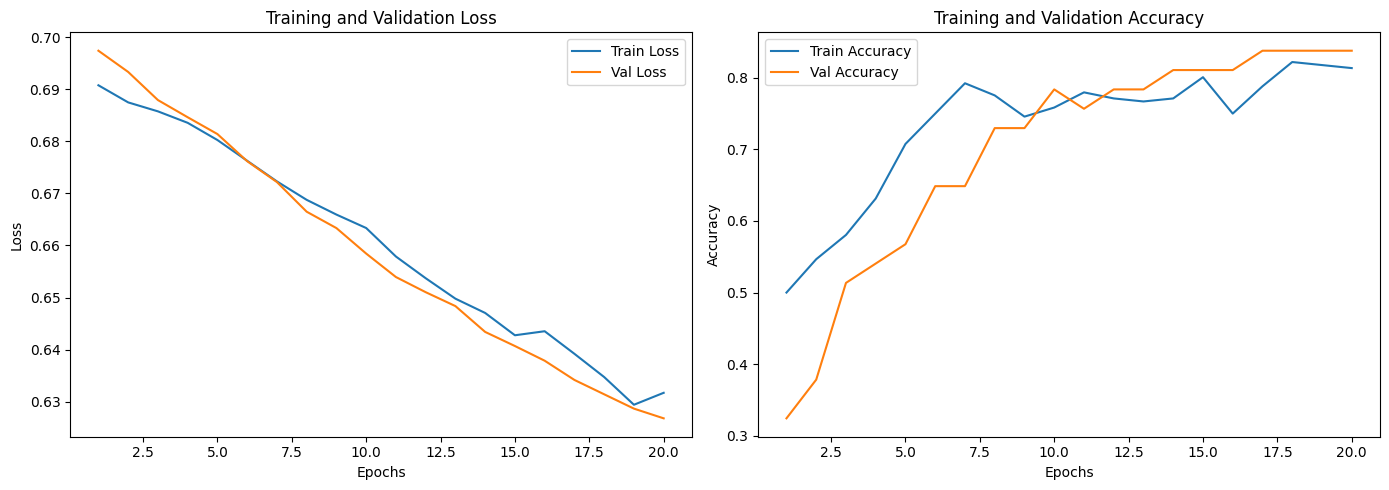

In [25]:
# ====================================================
# TRAINING LOOP WITH METRICS TRACKING
# ====================================================
best_val_loss = float('inf')
best_model_state = None
patience, patience_counter = 3, 0

# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):
    clip_model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Forward pass
        image_features = clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = (image_features @ text_features.T) * temperature

        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ================= Validation =================
    clip_model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            image_features = clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = (image_features @ text_features.T) * temperature

            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} - "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(clip_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

if best_model_state:
    clip_model.load_state_dict(best_model_state)

# ====================================================
# PLOT TRAIN/VAL LOSS AND ACCURACY
# ====================================================
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


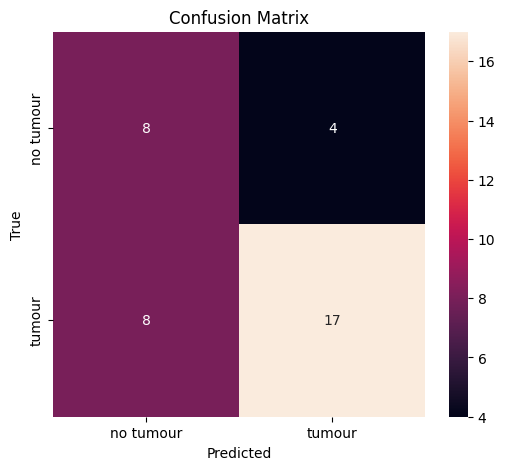

Classification Report:
              precision    recall  f1-score   support

   no tumour       0.50      0.67      0.57        12
      tumour       0.81      0.68      0.74        25

    accuracy                           0.68        37
   macro avg       0.65      0.67      0.66        37
weighted avg       0.71      0.68      0.68        37



In [26]:
# ====================================================
# TEST EVALUATION
# ====================================================
clip_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        image_features = clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = (image_features @ text_features.T) * temperature
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [118]:
# SAVE MODEL & RELATED COMPONENTS
save_path = "biomedclip_finetuned.pth"
torch.save({
    "model_state_dict": clip_model.state_dict(),
    "temperature": temperature.item(),
    "text_features": text_features.cpu(),  # Save normalized text features
    "label2id": label2id,                  # Save class mapping
    "class_names": class_names,            # Save class names
}, save_path)
print(f"Model saved to {save_path}")

Model saved to biomedclip_finetuned.pth


In [4]:
import torch
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A
from open_clip import create_model_from_pretrained, get_tokenizer

class TumourPredictor:
    def __init__(self, checkpoint_path, device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load BioMedCLIP base
        self.model, _ = create_model_from_pretrained(
            'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
        )
        self.model.to(self.device)
        self.model.eval()
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"], strict=False)
        self.temperature = torch.tensor(checkpoint["temperature"]).to(self.device)
        self.text_features = checkpoint["text_features"].to(self.device)
        self.class_names = checkpoint["class_names"]
        self.label2id = checkpoint["label2id"]
        
        # Albumentations inference transform (must match training)
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2()
        ])
    
    def predict_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)["image"].unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(img)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = (image_features @ self.text_features.T) * self.temperature
            probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()
        
        pred_idx = probs.argmax()
        return {
            "label": self.class_names[pred_idx],
            "confidence": float(probs[pred_idx])
        }


In [121]:
predictor = TumourPredictor("biomedclip_finetuned.pth")
result = predictor.predict_image("/home/cirdanmsc/gdrive/Cirdan1/pngs_v2/20170608_135222.isyntax.png")
print(result)

{'label': 'tumour', 'confidence': 0.5732753276824951}


In [130]:
class TumourBatchPredictor:
    def __init__(self, checkpoint_path, device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load BioMedCLIP base
        self.model, _ = create_model_from_pretrained(
            'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
        )
        self.model.to(self.device)
        self.model.eval()
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"], strict=False)
        self.temperature = torch.tensor(checkpoint["temperature"]).to(self.device)
        self.text_features = checkpoint["text_features"].to(self.device)
        self.class_names = checkpoint["class_names"]
        self.label2id = checkpoint["label2id"]
        
        # Albumentations inference transform (must match training)
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2()
        ])

    def predict_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(image=img)["image"].unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(img)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = (image_features @ self.text_features.T) * self.temperature
            probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()
        
        pred_idx = probs.argmax()
        return {
            "label": self.class_names[pred_idx],
            "confidence": float(probs[pred_idx])
        }

    def predict_folder(self, folder_path, output_csv="predictions.csv"):
        results = []
        for file_name in tqdm(os.listdir(folder_path), desc="Predicting"):
            if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(folder_path, file_name)
                pred = self.predict_image(img_path)
                results.append({
                    "image": file_name,
                    "prediction": pred["label"],
                    "confidence": pred["confidence"]
                })

        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f"Predictions saved to {output_csv}")
        return df

In [131]:
predictor = TumourBatchPredictor("biomedclip_finetuned.pth")
df_result = predictor.predict_folder("/home/cirdanmsc/gdrive/Cirdan1/pngs_v2")
print(df_result)

Predicting: 100%|███████████████████████████████████████████████████████████████████| 257/257 [1:09:18<00:00, 16.18s/it]

Predictions saved to predictions.csv
                                                 image prediction  confidence
0    1.3.46.670589.45.1.1.61596268946064.1.3788.147...     tumour    0.509704
1    1.3.46.670589.45.1.1.61596268946064.1.3788.147...     tumour    0.516669
2    1.3.46.670589.45.1.1.61596268946064.1.3788.147...  no tumour    0.515675
3    1.3.46.670589.45.1.1.61596268946064.1.3788.147...  no tumour    0.563334
4    1.3.46.670589.45.1.1.61596268946064.1.3788.147...     tumour    0.548928
..                                                 ...        ...         ...
252                        20170609_090153.isyntax.png     tumour    0.535254
253                        20170609_090348.isyntax.png  no tumour    0.531393
254                        20170609_090527.isyntax.png     tumour    0.556565
255                        20170609_090607.isyntax.png     tumour    0.555224
256                        20170609_091044.isyntax.png     tumour    0.529997

[257 rows x 3 columns]


In [132]:
df_result['prediction'].value_counts()

prediction
tumour       153
no tumour    104
Name: count, dtype: int64

In [36]:
import torch
import torch.nn.functional as F
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer
from torchvision import transforms

class TumourPredictor:
    def __init__(self, checkpoint_path, device=None):
        """
        Initializes BioMedCLIP with your fine-tuned weights for binary tumour classification.
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load BioMedCLIP
        self.model, self.preprocess = create_model_from_pretrained(
            'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
        )
        self.model.to(self.device)
        self.model.eval()

        # Load tokenizer
        self.tokenizer = get_tokenizer(
            'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
        )

        # Load fine-tuned weights
        state_dict = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(state_dict, strict=False)

        # Initialize text prompts (same as used in training)
        self.class_names = ['no tumour', 'tumour']
        text_prompts = [f"This image of breast tissue contains {label}" for label in self.class_names]

        with torch.no_grad():
            tokenized = self.tokenizer(text_prompts).to(self.device)
            self.text_features = self.model.encode_text(tokenized)
            self.text_features = self.text_features / self.text_features.norm(dim=-1, keepdim=True)

        # Temperature (you trained it as a parameter)
        self.temperature = torch.tensor(1.0).to(self.device)  # If you saved temperature, load it instead.

    def predict(self, image_path):
        """
        Predict tumour or no tumour for a single image.
        """
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(image_tensor)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            logits = (image_features @ self.text_features.T) * self.temperature
            probs = F.softmax(logits, dim=-1).cpu().numpy().flatten()

        pred_idx = probs.argmax()
        return {"label": self.class_names[pred_idx], "confidence": float(probs[pred_idx])}


In [37]:
predictor = TumourPredictor("finetuned_biomedclip.pth")
result = predictor.predict("/home/cirdanmsc/gdrive/Cirdan1/pngs_v2/20170608_135006.isyntax.png")
print(result)

{'label': 'no tumour', 'confidence': 0.5299661159515381}


In [38]:
df

,Slide Number,Tumour
0,20170608_135006,tumour
1,20170608_135049,tumour
2,20170608_135119,tumour
3,20170608_135222,tumour
4,20170608_135320,no tumour
...,...,...
245,1.3.46.670589.45.1.1.61596268946064.1.3788.148...,no tumour
246,1.3.46.670589.45.1.1.61596268946064.1.3788.148...,no tumour
247,1.3.46.670589.45.1.1.61596268946064.1.3788.148...,no tumour
248,1.3.46.670589.45.1.1.61596268946064.1.3788.148...,no tumour


In [39]:
def is_tumorous(slide_number):
    result = df[df['Slide Number'] == slide_number]['Tumour']
    if not result.empty:
        return bool(result.values[0])
    return None  # Slide not found

# Example usage
slide_id = 20170608_175717
status = is_tumorous(slide_id)

if status is None:
    print("Slide number not found.")
elif status:
    print("✅ Tumorous slide.")
else:
    print("❌ Non-tumorous slide.")


Slide number not found.


In [43]:
from crewai import Agent
from pydantic import PrivateAttr
# from tumour_predictor import TumourPredictor

class TumourAgent(Agent):
    _predictor: TumourPredictor = PrivateAttr()

    def __init__(self, checkpoint_path="biomedclip_finetuned.pth"):
        super().__init__(
            role="Medical Image Classifier",
            goal="Classify breast tissue images as tumour or no tumour.",
            backstory=(
                "An AI model fine-tuned on BioMedCLIP to detect breast cancer "
                "tumour presence with high accuracy."
            )
        )
        self._predictor = TumourPredictor(checkpoint_path)

    def run(self, image_path):
        """Analyze the image and return tumour prediction."""
        result = self._predictor.predict(image_path)
        label = result["label"]
        confidence = result["confidence"]
        return f"The image is classified as '{label}' with {confidence:.2f} confidence."


In [44]:
agent = TumourAgent("finetuned_biomedclip.pth")

# Example image
result = agent.run("/home/cirdanmsc/gdrive/Cirdan1/pngs_v2/20170608_135006.isyntax.png")
print(result)

The image is classified as 'no tumour' with 0.53 confidence.
